In [1]:
def displayMaze(maze, displayState, steps):
    # create a new figure
    plt.figure(figsize=(5, 5))

    # display the maze
    plt.imshow(maze, cmap=plt.cm.viridis, interpolation='nearest')
    plt.xticks([]), plt.yticks([])

    # measure the size of the maze and include it in the title
    height = maze.shape[0]
    width = maze.shape[1]


    # label the graph with the number of steps taken
    if steps > 0:
        plt.title(str(height) + "x" + str(width) + "- Steps: " + str(steps))

    if displayState:
        plt.show()

def createMP4(name, imgDirPath):
    # find the number of images in the folder
    numImages = len(os.listdir(imgDirPath))
    
    with imageio.get_writer(name + '.mp4', mode='I') as writer:
        # for each screenshot
        for i in range(1, numImages + 1):
            # read the screenshot
            image = imageio.imread(imgDirPath + "/" + str(i) + ".png")
            # add the screenshot to the video
            writer.append_data(image)
    
    # delete the screenshots
    for i in range(1, numImages + 1):
        os.remove(imgDirPath + "/" + str(i) + ".png")
        
    
    # speed up the video by a factor of 3x speed up
    os.system("ffmpeg -i " + name + ".mp4 -filter:v \"setpts=0.333*PTS\" " + name + "SpedUp.mp4 -y")

    # create a gif of the sped up video
    os.system("ffmpeg -i " + name + ".mp4 -pix_fmt rgb24 -r 10 " + name + ".gif -y")

In [2]:
# !pip install mazelib matplotlib

In [3]:
# import backtracking from mazelib package
from mazelib import Maze
from mazelib.generate.BacktrackingGenerator import BacktrackingGenerator

import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time
import sys
import os
import imageio.v2 as imageio

global bfsTime
global dfsTime
global bfsSteps
global dfsSteps
global aStarTime
global aStarSteps


bfsTime = []
dfsTime = []
bfsSteps = []
dfsSteps = []

aStarTime = []
aStarSteps = []

inputHeight = 0
inputWidth = 0

def generateMaze():
    # get the height and width of the maze from the user
    while True:
        try:
            
            height = int(input("Enter the height of the maze: "))  // 2
            width = int(input("Enter the width of the maze: "))  // 2
            break
        except ValueError:
            print("Please enter a valid integer.")

    # print the height and width of the maze 
    print("Generating a maze with a height of", height, "and a width of", width)
    # create a maze object
    newMaze = Maze()
    maze_generator = BacktrackingGenerator(width, height)
    newMaze = maze_generator.generate()

    # print the maze
    print(newMaze)

    newHeight = newMaze.shape[0]
    newWidth = newMaze.shape[1]
    print("The height of the maze is", newHeight, "and the width of the maze is", newWidth)

    # ensure that the maze is solvable by creating an entrance and exit in a random location on the top and bottom of the maze which must be connected to a 0 in the maze
    # create a list of all the 0s in the first and last row of the maze
    topRow = []
    bottomRow = []
    for i in range(newWidth):
        if newMaze[1][i] == 0:
            topRow.append(i)
        if newMaze[newHeight - 2][i] == 0:
            bottomRow.append(i)

    # randomly select a 0 from the top1 and bottom row
    top = random.choice(topRow)
    bottom = random.choice(bottomRow)

    # create an entrance and exit in the maze
    newMaze[0][top] = 0
    newMaze[newHeight - 1][bottom] = 0

    displayMaze(newMaze, True, 0)
    return newMaze

In [4]:
def findNeighbors(node, maze):
    # measure the height and width of the maze
    height = maze.shape[0]
    width = maze.shape[1]

    # create a list to store the neighbors of the node
    neighbors = []

    # if the node is not on the top row
    if node[0] != 0:
        # if the node is not a wall
        if maze[node[0] - 1][node[1]] == 0:
            # add the node above to the neighbors list
            neighbors.append((node[0] - 1, node[1]))

    # if the node is not on the bottom row
    if node[0] != height - 1:
        # if the node is not a wall
        if maze[node[0] + 1][node[1]] == 0:
            # add the node below to the neighbors list
            neighbors.append((node[0] + 1, node[1]))

    # if the node is not on the left side
    if node[1] != 0:
        # if the node is not a wall
        if maze[node[0]][node[1] - 1] == 0:
            # add the node to the left to the neighbors list
            neighbors.append((node[0], node[1] - 1))

    # if the node is not on the right side
    if node[1] != width - 1:
        # if the node is not a wall
        if maze[node[0]][node[1] + 1] == 0:
            # add the node to the right to the neighbors list
            neighbors.append((node[0], node[1] + 1))

    # return the neighbors list
    return neighbors

In [5]:
# animate the solving of the maze using BFS by taking a screenshot of each step and saving it to a folder and at the end creating a video of the screenshots to show the solving of the maze
def BFS(maze, bfsTime, bfsSteps):
    stepCount = 0

    # used to measure the time it takes to run BFS
    start_time = time.time()

    # measure the height and width of the maze
    height = maze.shape[0]
    width = maze.shape[1]

    # find the entrance and exit of the maze in the first and last row
    for i in range(width):
        if maze[0][i] == 0:
            start = (0, i)
        if maze[height - 1][i] == 0:
            end = (height - 1, i)

    # create a queue to store the nodes to be visited
    queue = []
    # add the start node to the queue
    queue.append(start)

    visited = []
    # create a dictionary to store the parent of each node
    parent = {}
    # set the parent of the start node to None
    parent[start] = None

    stepCount = 0

    # while the queue is not empty
    while queue:
        # increment the step count
        stepCount += 1

        # remove the first node from the queue
        node = queue.pop(0)

        # if the node is the end node
        if node == end:
            # break out of the loop
            break

        # if the node has not been visited
        if node not in visited:
            # add the node to the visited list
            visited.append(node)

            # find the neighbors of the node
            neighbors = findNeighbors(node, maze)

            # for each neighbor of the node
            for neighbor in neighbors:
                # if the neighbor has not been visited
                if neighbor not in visited:
                    # add the neighbor to the queue
                    queue.append(neighbor)
                    # set the parent of the neighbor to the node
                    parent[neighbor] = node

        # create a copy of the maze
        mazeCopy = maze.copy()
        for v in visited:
            mazeCopy[v[0]][v[1]] = 2 

        for q in queue:
            mazeCopy[q[0]][q[1]] = 3 

        displayMaze(mazeCopy, False, stepCount)
        plt.savefig("BFS/" + str(len(visited)) + ".png")
        plt.close()

    # This will be used to store the path from start to end
    path = []

    # Add the end node to the path
    path.append(end)

    # Check if the end node has a parent
    while end in parent:
        # If the end node has a parent, get the parent
        end = parent[end]
        # Add the parent to the path list
        path.append(end)

    # Reverse the path list
    path.reverse()
    path.pop(0)
    print(path)
    # This code creates a copy of the maze and sets the path to be colored. It then displays the image and saves it in the BFS folder with a name corresponding to the number of nodes visited.

    # measure the time it takes to run BFS
    end_time = time.time()
    elapsed_time = end_time - start_time
    stepCount = len(visited)
    bfsTime.append(elapsed_time)
    bfsSteps.append(stepCount)
    print(f"Elapsed time for Breadth-First Search: {elapsed_time} \| Steps: {stepCount}")

    # Create a copy of the maze
    mazeCopy = maze.copy()

    currentNumFiles = len(os.listdir("BFS"))

    # For each node in the path
    for node in path:
        # If the node is not the start node
        if node != start:
            # Set the node to be colored
            mazeCopy[node[0]][node[1]] = 10 
            # Display the maze in the background and add the screenshot to the BFS folder with a name corresponding to the number of nodes visited plus the initial number of files in the BFS folder
            displayMaze(mazeCopy, False, stepCount)
            plt.savefig("BFS/" + str(currentNumFiles + len(path) - path.index(node)) + ".png")
            plt.close()
    
    # Call the createMP4 function to create a video of the screenshots with the parameters of the name of the file and the folder the screenshots are in
    createMP4("BFS", "BFS")

# BFS(newMaze, bfsTime, bfsSteps)

In [6]:
# animate the solving of the maze using DFS by taking a screenshot of each step and saving it to a folder and at the end creating a video of the screenshots to show the solving of the maze
def DFS(maze, dfsTime, dfsSteps):
    # used to measure the time it takes to run DFS
    start_time = time.time()
    stepCount = 0

    # measure the height and width of the maze
    height = maze.shape[0]
    width = maze.shape[1]
    # find the entrance and exit of the maze in the first and last row
    for i in range(width):
        if maze[0][i] == 0:
            start = (0, i)
        if maze[height - 1][i] == 0:
            end = (height - 1, i)
    
    # create a stack to store the nodes to be visited
    stack = []
    # add the start node to the stack
    stack.append(start)

    visited = []
    # create a dictionary to store the parent of each node
    parent = {}
    # set the parent of the start node to None
    parent[start] = None
    while stack:
        stepCount += 1
        node = stack.pop()
        if node == end:
            break
        # if the node has not been visited
        if node not in visited:
            # add the node to the visited list
            visited.append(node)

            # find the neighbors of the node
            neighbors = findNeighbors(node, maze)

            # for each neighbor of the node
            for neighbor in neighbors:
                # if the neighbor has not been visited
                if neighbor not in visited:
                    # add the neighbor to the stack
                    stack.append(neighbor)
                    # set the parent of the neighbor to the node
                    parent[neighbor] = node

                # if the neighbor is the end node
                if neighbor == end:
                    # break out of the loop
                    break

        # create a copy of the maze
        mazeCopy = maze.copy()
        # for each node in the maze path
        for v in visited:
            # highlight the node
            mazeCopy[v[0]][v[1]] = 2 
        # for the current node highlight it in a different color to show that it is the current node
        for s in stack:
            mazeCopy[s[0]][s[1]] = 3 

        displayMaze(mazeCopy, False, stepCount)
        plt.savefig("DFS/" + str(len(visited)) + ".png")
        plt.close()

    path = []
    path.append(end)
    while end in parent:
        
        end = parent[end]
        path.append(end)
    path.reverse()
    path.pop(0)

    # measure the time it takes to run DFS
    end_time = time.time()
    elapsed_time = end_time - start_time
    dfsTime.append(elapsed_time)
    stepCount = len(visited)
    dfsSteps.append(stepCount)
    print(f"Elapsed time for Depth-First Search: {elapsed_time} \| Steps: {stepCount}")
    
    mazeCopy = maze.copy()
    currentNumFiles = len(os.listdir("DFS"))
    for node in path:
        if node != start:
            mazeCopy[node[0]][node[1]] = 10 
            displayMaze(mazeCopy, False, stepCount)
            plt.savefig("DFS/" + str(currentNumFiles + len(path) - path.index(node)) + ".png")
            plt.close()

    createMP4("DFS", "DFS")

# DFS(newMaze, dfsTime, dfsSteps)

In [7]:
# animate the solving of the maze using A* by taking a screenshot of each step and saving it to a folder and at the end creating a video of the screenshots to show the solving of the maze
from queue import PriorityQueue


def heuristic(node, end):
    return abs(node[0] - end[0]) + abs(node[1] - end[1])


def aStar(maze, aStarTime, aStarSteps):
    # used to measure the time it takes to run A*
    start_time = time.time()
    stepCount = 0

    # measure the height and width of the maze
    height = maze.shape[0]
    width = maze.shape[1]
    # find the entrance and exit of the maze in the first and last row
    for i in range(width):
        if maze[0][i] == 0:
            start = (0, i)
        if maze[height - 1][i] == 0:
            end = (height - 1, i)
    
    # create a priority queue to store the nodes to be visited
    queue = PriorityQueue()
    # add the start node to the queue
    queue.put((0, start))

    visited = []
    # create a dictionary to store the parent of each node
    parent = {}
    # set the parent of the start node to None
    parent[start] = None
    while queue:
        stepCount += 1
        node = queue.get()[1]
        if node == end:
            break
        # if the node has not been visited
        if node not in visited:
            # add the node to the visited list
            visited.append(node)

            # find the neighbors of the node
            neighbors = findNeighbors(node, maze)

            # for each neighbor of the node
            for neighbor in neighbors:
                # if the neighbor has not been visited
                if neighbor not in visited:
                    # add the neighbor to the queue
                    queue.put((heuristic(neighbor, end), neighbor))
                    # set the parent of the neighbor to the node
                    parent[neighbor] = node

                # if the neighbor is the end node
                if neighbor == end:
                    # break out of the loop
                    break

        # create a copy of the maze
        mazeCopy = maze.copy()
        # for each node in the maze path
        for v in visited:
            # highlight the node
            mazeCopy[v[0]][v[1]] = 2 
        # for the current node highlight it in a different color to show that it is the current node
        mazeCopy[node[0]][node[1]] = 3 

        displayMaze(mazeCopy, False, stepCount)
        plt.savefig("AStar/" + str(len(visited)) + ".png")
        plt.close()

    path = []
    path.append(end)
    while end in parent:
            
        end = parent[end]
        path.append(end)    
    path.reverse()
    path.pop(0)

    # measure the time it takes to run A*
    end_time = time.time()
    elapsed_time = end_time - start_time
    aStarTime.append(elapsed_time)
    stepCount = len(visited)
    aStarSteps.append(stepCount)
    print(f"Elapsed time for A*: {elapsed_time} \| Steps: {stepCount}")

    mazeCopy = maze.copy()
    currentNumFiles = len(os.listdir("AStar"))
    for node in path:
        if node != start:
            mazeCopy[node[0]][node[1]] = 10 
            displayMaze(mazeCopy, False, stepCount)
            plt.savefig("AStar/" + str(currentNumFiles + len(path) - path.index(node)) + ".png")
            plt.close()
    createMP4("AStar", "AStar")
    



Generating a maze with a height of 20 and a width of 20
[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 1 ... 1 0 1]
 ...
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 0 0 1]
 [1 1 1 ... 1 1 1]]
The height of the maze is 41 and the width of the maze is 41


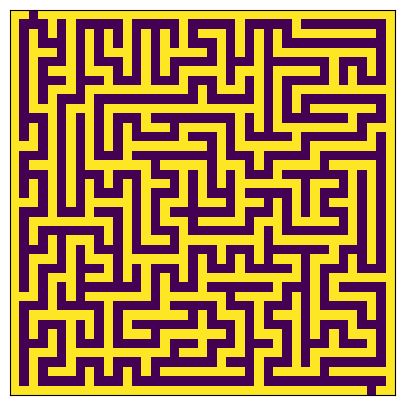

[(0, 2), (1, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (11, 2), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (15, 2), (15, 1), (16, 1), (17, 1), (17, 2), (17, 3), (18, 3), (19, 3), (20, 3), (21, 3), (21, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (25, 2), (25, 3), (24, 3), (23, 3), (23, 4), (23, 5), (24, 5), (25, 5), (26, 5), (27, 5), (27, 4), (27, 3), (28, 3), (29, 3), (30, 3), (31, 3), (31, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (35, 2), (35, 3), (34, 3), (33, 3), (33, 4), (33, 5), (34, 5), (35, 5), (36, 5), (37, 5), (37, 4), (37, 3), (38, 3), (39, 3), (39, 4), (39, 5), (39, 6), (39, 7), (38, 7), (37, 7), (37, 8), (37, 9), (38, 9), (39, 9), (39, 10), (39, 11), (38, 11), (37, 11), (37, 12), (37, 13), (38, 13), (39, 13), (39, 14), (39, 15), (38, 15), (37, 15), (37, 16), (37, 17), (37, 18), (37, 19), (37, 20), (37, 21), (36, 21), (35, 21), (35, 22), (35, 23), (34, 23), (33, 23), (33, 22), (33, 21), (32, 21), (31, 21), (

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for Depth-First Search: 11.875596046447754 \| Steps: 303


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for A*: 13.555593013763428 \| Steps: 333


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Generating a maze with a height of 20 and a width of 20
[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 1 ... 1 1 1]
 ...
 [1 0 1 ... 1 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]
The height of the maze is 41 and the width of the maze is 41


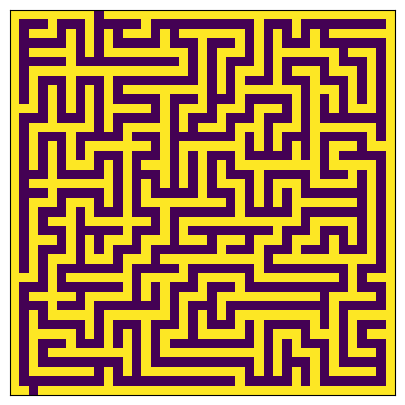

[(0, 9), (1, 9), (1, 10), (1, 11), (2, 11), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (2, 15), (1, 15), (1, 16), (1, 17), (2, 17), (3, 17), (3, 18), (3, 19), (4, 19), (5, 19), (6, 19), (7, 19), (7, 18), (7, 17), (7, 16), (7, 15), (7, 14), (7, 13), (7, 12), (7, 11), (8, 11), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 15), (11, 15), (11, 14), (11, 13), (11, 12), (11, 11), (12, 11), (13, 11), (13, 10), (13, 9), (12, 9), (11, 9), (10, 9), (9, 9), (8, 9), (7, 9), (7, 8), (7, 7), (8, 7), (9, 7), (10, 7), (11, 7), (11, 6), (11, 5), (10, 5), (9, 5), (8, 5), (7, 5), (7, 4), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (11, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (17, 2), (17, 3), (16, 3), (15, 3), (14, 3), (13, 3), (13, 4), (13, 5), (14, 5), (15, 5), (16, 5), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (16, 9), (15, 9), (15, 10), (15, 11), (16, 11), (17, 11), (18, 11), (19, 11), (20, 11), (21, 11), (21, 10), (21, 9), (20, 9), (19, 9), (19, 8), (19, 7), (19, 6)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for Depth-First Search: 26.795143604278564 \| Steps: 703


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for A*: 7.214885473251343 \| Steps: 200


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Generating a maze with a height of 20 and a width of 20
[[1 1 1 ... 1 1 1]
 [1 0 0 ... 1 0 1]
 [1 0 1 ... 1 0 1]
 ...
 [1 0 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]
The height of the maze is 41 and the width of the maze is 41


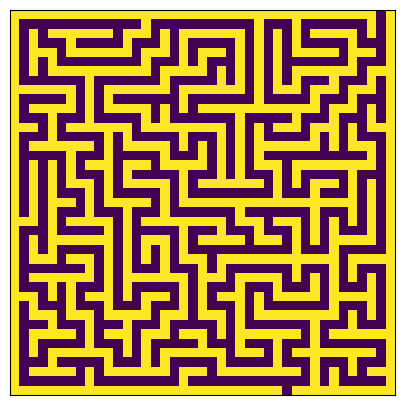

[(0, 39), (1, 39), (2, 39), (3, 39), (4, 39), (5, 39), (5, 38), (5, 37), (6, 37), (7, 37), (7, 36), (7, 35), (8, 35), (9, 35), (9, 34), (9, 33), (10, 33), (11, 33), (11, 32), (11, 31), (12, 31), (13, 31), (13, 30), (13, 29), (13, 28), (13, 27), (12, 27), (11, 27), (11, 26), (11, 25), (12, 25), (13, 25), (14, 25), (15, 25), (16, 25), (17, 25), (17, 26), (17, 27), (18, 27), (19, 27), (19, 26), (19, 25), (19, 24), (19, 23), (19, 22), (19, 21), (19, 20), (19, 19), (18, 19), (17, 19), (17, 20), (17, 21), (16, 21), (15, 21), (14, 21), (13, 21), (13, 20), (13, 19), (14, 19), (15, 19), (15, 18), (15, 17), (14, 17), (13, 17), (13, 16), (13, 15), (13, 14), (13, 13), (12, 13), (11, 13), (11, 12), (11, 11), (11, 10), (11, 9), (10, 9), (9, 9), (8, 9), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (6, 15), (5, 15), (5, 16), (5, 17), (4, 17), (3, 17), (2, 17), (1, 17), (1, 16), (1, 15), (2, 15), (3, 15), (3, 14), (3, 13), (4, 13), (5, 13), (5, 12), (5, 11), (5, 10), (5, 9), (5, 8), (5

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for Depth-First Search: 15.371026039123535 \| Steps: 410


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for A*: 15.60435938835144 \| Steps: 410


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Generating a maze with a height of 30 and a width of 30
[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 1 ... 1 0 1]
 ...
 [1 1 1 ... 1 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]
The height of the maze is 61 and the width of the maze is 61


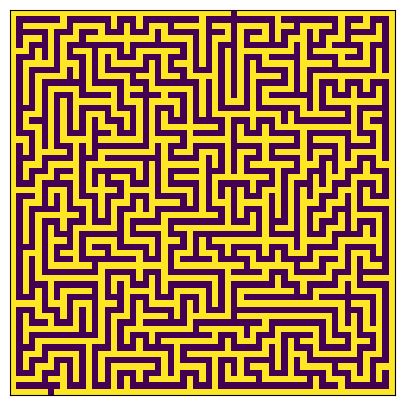

[(0, 35), (1, 35), (1, 34), (1, 33), (1, 32), (1, 31), (2, 31), (3, 31), (4, 31), (5, 31), (6, 31), (7, 31), (8, 31), (9, 31), (9, 30), (9, 29), (8, 29), (7, 29), (6, 29), (5, 29), (4, 29), (3, 29), (3, 28), (3, 27), (3, 26), (3, 25), (2, 25), (1, 25), (1, 24), (1, 23), (1, 22), (1, 21), (2, 21), (3, 21), (3, 20), (3, 19), (2, 19), (1, 19), (1, 18), (1, 17), (2, 17), (3, 17), (3, 16), (3, 15), (2, 15), (1, 15), (1, 14), (1, 13), (1, 12), (1, 11), (1, 10), (1, 9), (2, 9), (3, 9), (3, 8), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7), (9, 6), (9, 5), (9, 4), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (15, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (19, 2), (19, 3), (20, 3), (21, 3), (22, 3), (23, 3), (23, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (27, 2), (27, 3), (26, 3), (25, 3), (25, 4), (25, 5), (24, 5), (23, 5), (23, 6), (23, 7), (23, 8), (23, 9), (22, 9), (21, 9), (21, 8), (21, 7), (20, 7), (19, 7), (18, 7), (17, 7), (16, 7), (15, 7), (14, 7

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for Depth-First Search: 25.348718643188477 \| Steps: 667


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for A*: 21.59502077102661 \| Steps: 595


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Generating a maze with a height of 30 and a width of 30
[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 1 ... 1 0 1]
 ...
 [1 1 1 ... 1 0 1]
 [1 0 0 ... 1 0 1]
 [1 1 1 ... 1 1 1]]
The height of the maze is 61 and the width of the maze is 61


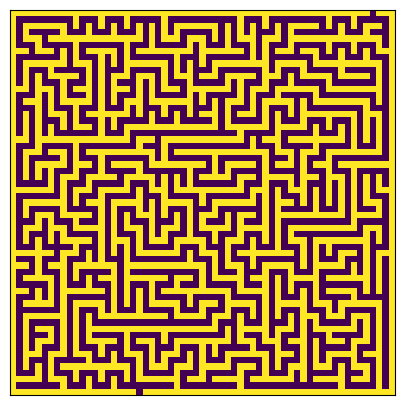

[(0, 57), (1, 57), (1, 56), (1, 55), (2, 55), (3, 55), (3, 54), (3, 53), (2, 53), (1, 53), (1, 52), (1, 51), (2, 51), (3, 51), (3, 50), (3, 49), (2, 49), (1, 49), (1, 48), (1, 47), (1, 46), (1, 45), (1, 44), (1, 43), (2, 43), (3, 43), (4, 43), (5, 43), (5, 42), (5, 41), (6, 41), (7, 41), (7, 42), (7, 43), (7, 44), (7, 45), (6, 45), (5, 45), (5, 46), (5, 47), (5, 48), (5, 49), (6, 49), (7, 49), (7, 50), (7, 51), (6, 51), (5, 51), (5, 52), (5, 53), (6, 53), (7, 53), (7, 54), (7, 55), (6, 55), (5, 55), (5, 56), (5, 57), (6, 57), (7, 57), (7, 58), (7, 59), (8, 59), (9, 59), (10, 59), (11, 59), (12, 59), (13, 59), (14, 59), (15, 59), (15, 58), (15, 57), (14, 57), (13, 57), (13, 56), (13, 55), (13, 54), (13, 53), (13, 52), (13, 51), (13, 50), (13, 49), (12, 49), (11, 49), (11, 48), (11, 47), (11, 46), (11, 45), (10, 45), (9, 45), (9, 44), (9, 43), (10, 43), (11, 43), (11, 42), (11, 41), (12, 41), (13, 41), (13, 40), (13, 39), (14, 39), (15, 39), (16, 39), (17, 39), (17, 38), (17, 37), (17, 3

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for Depth-First Search: 22.28595232963562 \| Steps: 585


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

Elapsed time for A*: 48.12979245185852 \| Steps: 1251


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --en

In [8]:
heightsWidthsArray = []

for i in range(5):
  currMaze = generateMaze()
  # get the dimensions of the current array and add it to a list
  heightsWidthsArray.append(currMaze.shape)
  BFS(currMaze, bfsTime, bfsSteps)
  DFS(currMaze, dfsTime, dfsSteps)
  aStar(currMaze, aStarTime, aStarSteps)



DFS Times: [11.875596046447754, 26.795143604278564, 15.371026039123535, 25.348718643188477, 22.28595232963562]
BFS Times: [13.54269289970398, 18.356316804885864, 19.53450632095337, 64.43275237083435, 54.01006817817688]


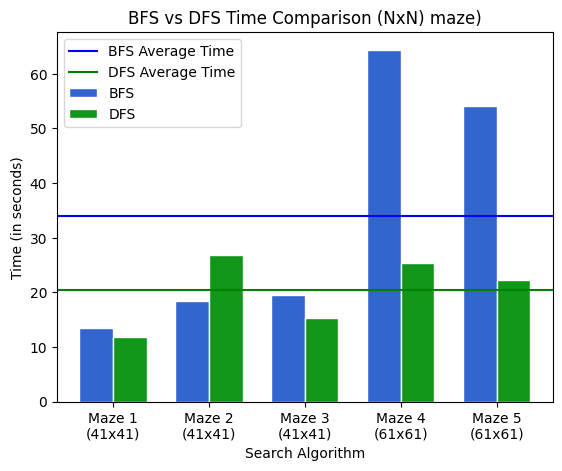

In [9]:
print("DFS Times:", dfsTime)
print("BFS Times:", bfsTime)

averageDFSTime = sum(dfsTime) / len(dfsTime)
averageBFSTime = sum(bfsTime) / len(bfsTime)


# X-axis labels
labels = []
for i in range(len(heightsWidthsArray)):
    labels.append('Maze ' + str(i + 1)+ "\n" +"("+ str(heightsWidthsArray[i][0]) + "x" + str(heightsWidthsArray[i][1])+ ")")

# Set the width of each bar
barWidth = 0.35

# Set the position of each bar on the X-axis
r1 = np.arange(len(bfsTime))
r2 = [x + barWidth for x in r1]

# Define consistent colors for each search
bfsColor = ['#3366CC', '#3366CC', '#3366CC', '#3366CC', '#3366CC']
dfsColor = ['#109618', '#109618', '#109618', '#109618', '#109618']

# Plotting the bar graph
plt.bar(r1, bfsTime, color=bfsColor, width=barWidth, edgecolor='white', label='BFS')
plt.bar(r2, dfsTime, color=dfsColor, width=barWidth, edgecolor='white', label='DFS')

# Adding labels and title
plt.xlabel('Search Algorithm')
plt.ylabel('Time (in seconds)')
plt.title(f'BFS vs DFS Time Comparison (NxN) maze)')

# add average time to the graph
plt.axhline(y=averageBFSTime, color='b', linestyle='-', label='BFS Average Time')
plt.axhline(y=averageDFSTime, color='g', linestyle='-', label='DFS Average Time')

# Adding X-axis labels
plt.xticks([r + barWidth/2 for r in range(len(bfsTime))], labels)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

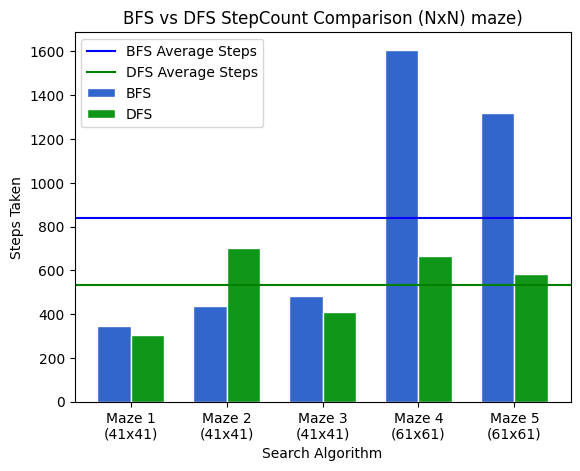

In [10]:
# X-axis labels
labels = []
for i in range(len(heightsWidthsArray)):
    labels.append('Maze ' + str(i + 1) + "\n" +"("+ str(heightsWidthsArray[i][0]) + "x" + str(heightsWidthsArray[i][1])+ ")")

# Set the width of each bar
barWidth = 0.35

# Set the position of each bar on the X-axis
r1 = np.arange(len(bfsSteps))
r2 = [x + barWidth for x in r1]

# Define consistent colors for each search
bfsColor = ['#3366CC', '#3366CC', '#3366CC', '#3366CC', '#3366CC']
dfsColor = ['#109618', '#109618', '#109618', '#109618', '#109618']

averageBFSSteps = sum(bfsSteps) / len(bfsSteps)
averageDFSSteps = sum(dfsSteps) / len(dfsSteps)


# Plotting the bar graph
plt.bar(r1, bfsSteps, color=bfsColor, width=barWidth, edgecolor='white', label='BFS')
plt.bar(r2, dfsSteps, color=dfsColor, width=barWidth, edgecolor='white', label='DFS')

# Adding labels and title
plt.xlabel('Search Algorithm')
plt.ylabel('Steps Taken')
plt.title(f'BFS vs DFS StepCount Comparison (NxN) maze)')

# add average time to the graph
plt.axhline(y=averageBFSSteps, color='b', linestyle='-', label='BFS Average Steps')
plt.axhline(y=averageDFSSteps, color='g', linestyle='-', label='DFS Average Steps')


# Adding X-axis labels
plt.xticks([r + barWidth/2 for r in range(len(bfsSteps))], labels)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

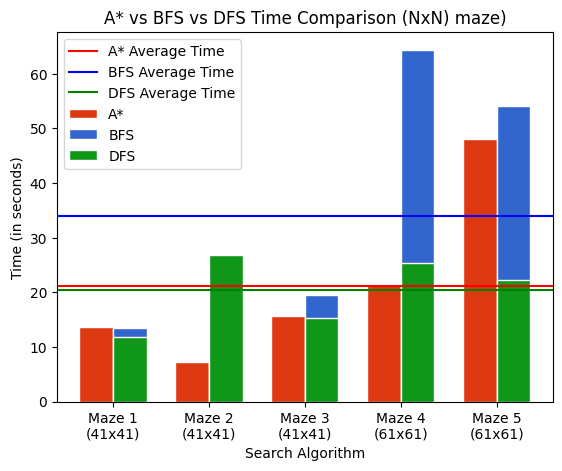

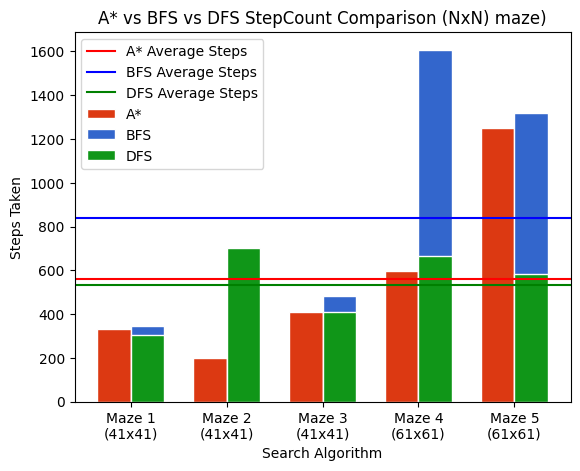

In [11]:
# X-axis labels
labels = []
for i in range(len(heightsWidthsArray)):
    labels.append('Maze ' + str(i + 1) + "\n" +"("+ str(heightsWidthsArray[i][0]) + "x" + str(heightsWidthsArray[i][1])+ ")")

# Set the width of each bar
barWidth = 0.35

# Set the position of each bar on the X-axis
r1 = np.arange(len(aStarTime))
r2 = [x + barWidth for x in r1]

# Define consistent colors for each search
bfsColor = ['#3366CC', '#3366CC', '#3366CC', '#3366CC', '#3366CC']
dfsColor = ['#109618', '#109618', '#109618', '#109618', '#109618']
aStarColor = ['#DC3912', '#DC3912', '#DC3912', '#DC3912', '#DC3912']

averageAStarTime = sum(aStarTime) / len(aStarTime)
averageAStarSteps = sum(aStarSteps) / len(aStarSteps)

# Plotting the bar graph
plt.bar(r1, aStarTime, color=aStarColor, width=barWidth, edgecolor='white', label='A*')
plt.bar(r2, bfsTime, color=bfsColor, width=barWidth, edgecolor='white', label='BFS')
plt.bar(r2, dfsTime, color=dfsColor, width=barWidth, edgecolor='white', label='DFS')

# Adding labels and title
plt.xlabel('Search Algorithm')
plt.ylabel('Time (in seconds)')
plt.title(f'A* vs BFS vs DFS Time Comparison (NxN) maze)')
# add average time to the graph
plt.axhline(y=averageAStarTime, color='r', linestyle='-', label='A* Average Time')
plt.axhline(y=averageBFSTime, color='b', linestyle='-', label='BFS Average Time')
plt.axhline(y=averageDFSTime, color='g', linestyle='-', label='DFS Average Time')

# Adding X-axis labels
plt.xticks([r + barWidth/2 for r in range(len(aStarTime))], labels)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

# X-axis labels
labels = []
for i in range(len(heightsWidthsArray)):
    labels.append('Maze ' + str(i + 1) + "\n" +"("+ str(heightsWidthsArray[i][0]) + "x" + str(heightsWidthsArray[i][1])+ ")")

# Set the width of each bar
barWidth = 0.35

# Set the position of each bar on the X-axis
r1 = np.arange(len(aStarSteps))
r2 = [x + barWidth for x in r1]

# Define consistent colors for each search
bfsColor = ['#3366CC', '#3366CC', '#3366CC', '#3366CC', '#3366CC']
dfsColor = ['#109618', '#109618', '#109618', '#109618', '#109618']
aStarColor = ['#DC3912', '#DC3912', '#DC3912', '#DC3912', '#DC3912']

averageAStarSteps = sum(aStarSteps) / len(aStarSteps)
averageBFSSteps = sum(bfsSteps) / len(bfsSteps)
averageDFSSteps = sum(dfsSteps) / len(dfsSteps)

# Plotting the bar graph
plt.bar(r1, aStarSteps, color=aStarColor, width=barWidth, edgecolor='white', label='A*')
plt.bar(r2, bfsSteps, color=bfsColor, width=barWidth, edgecolor='white', label='BFS')
plt.bar(r2, dfsSteps, color=dfsColor, width=barWidth, edgecolor='white', label='DFS')

# Adding labels and title
plt.xlabel('Search Algorithm')
plt.ylabel('Steps Taken')
plt.title(f'A* vs BFS vs DFS StepCount Comparison (NxN) maze)')
# add average time to the graph
plt.axhline(y=averageAStarSteps, color='r', linestyle='-', label='A* Average Steps')
plt.axhline(y=averageBFSSteps, color='b', linestyle='-', label='BFS Average Steps')
plt.axhline(y=averageDFSSteps, color='g', linestyle='-', label='DFS Average Steps')

# Adding X-axis labels
plt.xticks([r + barWidth/2 for r in range(len(aStarSteps))], labels)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()
